<a href="https://colab.research.google.com/github/pachterlab/kallistobustools/blob/master/tutorials/docs/tutorials/kb_kite/python/kb_kite.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Pre-processing and analysis of feature barcode single-cell RNA-seq data with KITE.

In this notebook, we will perform pre-processing and analysis of [10x Genomics pbmc_1k_protein_v3](https://support.10xgenomics.com/single-cell-gene-expression/datasets/3.0.0/pbmc_1k_protein_v3) feature barcoding dataset using the **Kallisto Indexing and Tag Extraction (KITE)** workflow, implemented with a wrapper called `kb`. It was developed by Kyung Hoi (Joseph) Min and A. Sina Booeshaghi.

In Feature Barcoding assays, cellular data are recorded as short DNA sequences using procedures adapted from single-cell RNA-seq. The **KITE** workflow generates a "Mismatch Map" containing the sequences of all Feature Barcodes used in the experiment as well as all of their single-base mismatches. The Mismatch Map is used to produce transcipt-to-gene (.t2g) and fasta (.fa) files to be used as inputs for kallisto. An index is made with kallisto index, then kallisto | bustools effectively searches the sequencing data for the sequences in the Mismatch Map.

## Pre-processing

### Download the data

__Note:__ We use the `-O` option for `wget` to rename the files to easily identify them.

In [1]:
%%time
!wget -q https://caltech.box.com/shared/static/asmj4nu90ydhsrk3pm7aaxu00cnnfige.txt -O checksums.txt
!wget -q https://caltech.box.com/shared/static/mp2vr3p6dztdyatuag8ir3cektmrztg8.gz -O pbmc_1k_protein_v3_antibody_S2_L001_R1_001.fastq.gz
!wget -q https://caltech.box.com/shared/static/f3payi1za7mn0jfai7vm10sy3yqwgpqh.gz -O pbmc_1k_protein_v3_antibody_S2_L001_R2_001.fastq.gz
!wget -q https://caltech.box.com/shared/static/e112bbczh9o1rl6gfin36bqp0ga7uvdy.gz -O pbmc_1k_protein_v3_antibody_S2_L002_R1_001.fastq.gz
!wget -q https://caltech.box.com/shared/static/3ve2axc8dr8v5nnrhmynrdgpqj6xg42k.gz -O pbmc_1k_protein_v3_antibody_S2_L002_R2_001.fastq.gz

CPU times: user 477 ms, sys: 86.2 ms, total: 563 ms
Wall time: 1min


Then, we verify the integrity of the files we downloaded to make sure they were not corrupted during the download.

In [2]:
!md5sum -c checksums.txt --ignore-missing

pbmc_1k_protein_v3_antibody_S2_L001_R1_001.fastq.gz: OK
pbmc_1k_protein_v3_antibody_S2_L001_R2_001.fastq.gz: OK
pbmc_1k_protein_v3_antibody_S2_L002_R1_001.fastq.gz: OK
pbmc_1k_protein_v3_antibody_S2_L002_R2_001.fastq.gz: OK


### Install `kb`

Install `kb` for running the kallisto|bustools workflow.

In [12]:
!pip install --quiet git+https://github.com/pachterlab/kb_python@devel

     |████████████████████████████████| 51kB 2.6MB/s 
     |████████████████████████████████| 13.2MB 314kB/s 
     |████████████████████████████████| 112kB 43.4MB/s 


### Build the feature barcode mismatch index

`kb` is able to generate a FASTA file containing all hamming distance < 2 variants of the feature barcodes and create a kallisto index of these sequences. But it in order to do so, we first need to prepare a TSV containing feature barcode sequences in the first column and the feature barcode names in the second.

First, we download the feature reference file provided by 10x Genomics.

In [13]:
!wget -q http://cf.10xgenomics.com/samples/cell-exp/3.0.0/pbmc_1k_protein_v3/pbmc_1k_protein_v3_feature_ref.csv

Let's load it in as a Pandas DataFrame.

In [14]:
import pandas as pd

df = pd.read_csv('pbmc_1k_protein_v3_feature_ref.csv')
df

,id,name,read,pattern,sequence,feature_type
0,CD3,CD3_TotalSeqB,R2,5PNNNNNNNNNN(BC)NNNNNNNNN,AACAAGACCCTTGAG,Antibody Capture
1,CD4,CD4_TotalSeqB,R2,5PNNNNNNNNNN(BC)NNNNNNNNN,TACCCGTAATAGCGT,Antibody Capture
2,CD8a,CD8a_TotalSeqB,R2,5PNNNNNNNNNN(BC)NNNNNNNNN,ATTGGCACTCAGATG,Antibody Capture
3,CD14,CD14_TotalSeqB,R2,5PNNNNNNNNNN(BC)NNNNNNNNN,GAAAGTCAAAGCACT,Antibody Capture
4,CD15,CD15_TotalSeqB,R2,5PNNNNNNNNNN(BC)NNNNNNNNN,ACGAATCAATCTGTG,Antibody Capture
5,CD16,CD16_TotalSeqB,R2,5PNNNNNNNNNN(BC)NNNNNNNNN,GTCTTTGTCAGTGCA,Antibody Capture
6,CD56,CD56_TotalSeqB,R2,5PNNNNNNNNNN(BC)NNNNNNNNN,GTTGTCCGACAATAC,Antibody Capture
7,CD19,CD19_TotalSeqB,R2,5PNNNNNNNNNN(BC)NNNNNNNNN,TCAACGCTTGGCTAG,Antibody Capture
8,CD25,CD25_TotalSeqB,R2,5PNNNNNNNNNN(BC)NNNNNNNNN,GTGCATTCAACAGTA,Antibody Capture
9,CD45RA,CD45RA_TotalSeqB,R2,5PNNNNNNNNNN(BC)NNNNNNNNN,GATGAGAACAGGTTT,Antibody Capture


We'll convert this dataframe into a TSV format that `kb` requires.

In [15]:
df[['sequence', 'id']].to_csv('features.tsv', index=None, header=None, sep='\t')
!cat features.tsv

AACAAGACCCTTGAG	CD3
TACCCGTAATAGCGT	CD4
ATTGGCACTCAGATG	CD8a
GAAAGTCAAAGCACT	CD14
ACGAATCAATCTGTG	CD15
GTCTTTGTCAGTGCA	CD16
GTTGTCCGACAATAC	CD56
TCAACGCTTGGCTAG	CD19
GTGCATTCAACAGTA	CD25
GATGAGAACAGGTTT	CD45RA
TGCATGTCATCGGTG	CD45RO
AAGTCGTGAGGCATG	PD-1
TGAAGGCTCATTTGT	TIGIT
ACATTGACGCAACTA	CD127
CTCTATTCAGACCAG	IgG2a
ACTCACTGGAGTCTC	IgG1
ATCACATCGTTGCCA	IgG2b


Finally, we use `kb` to generate the mismatch kallisto index.

In [16]:
!kb ref -i mismatch.idx -f1 mismatch.fa -g t2g.txt --workflow kite features.tsv

[2021-03-31 23:30:15,970]    INFO Generating mismatch FASTA at mismatch.fa
[2021-03-31 23:30:15,982]    INFO Creating transcript-to-gene mapping at t2g.txt
[2021-03-31 23:30:15,986]    INFO Indexing mismatch.fa to mismatch.idx


### Generate a feature count matrix in H5AD format

The following command will generate an RNA count matrix of cells (rows) by genes (columns) in H5AD format, which is a binary format used to store [Anndata](https://anndata.readthedocs.io/en/stable/) objects. Notice we are providing the index and transcript-to-gene mapping we generated in the previous step to the `-i` and `-g` arguments respectively. Also, these reads were generated with the 10x Genomics Chromium Single Cell v3 Chemistry, hence the `-x 10xv3` argument. To view other supported technologies, run `kb --list`.

__Note:__ If you would like a Loom file instead, replace the `--h5ad` flag with `--loom`. If you want to use the raw matrix output by `kb` instead of their H5AD or Loom converted files, omit these flags.

In [17]:
%%time
!kb count --h5ad -i mismatch.idx -g t2g.txt -x 10xv3 --workflow kite -t 2 \
pbmc_1k_protein_v3_antibody_S2_L001_R1_001.fastq.gz \
pbmc_1k_protein_v3_antibody_S2_L001_R2_001.fastq.gz \
pbmc_1k_protein_v3_antibody_S2_L002_R1_001.fastq.gz \
pbmc_1k_protein_v3_antibody_S2_L002_R2_001.fastq.gz

[2021-03-31 23:30:17,474]    INFO Using index mismatch.idx to generate BUS file to . from
[2021-03-31 23:30:17,474]    INFO         pbmc_1k_protein_v3_antibody_S2_L001_R1_001.fastq.gz
[2021-03-31 23:30:17,474]    INFO         pbmc_1k_protein_v3_antibody_S2_L001_R2_001.fastq.gz
[2021-03-31 23:30:17,474]    INFO         pbmc_1k_protein_v3_antibody_S2_L002_R1_001.fastq.gz
[2021-03-31 23:30:17,474]    INFO         pbmc_1k_protein_v3_antibody_S2_L002_R2_001.fastq.gz
[2021-03-31 23:32:02,567]    INFO Sorting BUS file ./output.bus to ./tmp/output.s.bus
[2021-03-31 23:32:18,183]    INFO Whitelist not provided
[2021-03-31 23:32:18,183]    INFO Copying pre-packaged 10XV3 whitelist to .
[2021-03-31 23:32:19,157]    INFO Inspecting BUS file ./tmp/output.s.bus
[2021-03-31 23:32:31,284]    INFO Correcting BUS records in ./tmp/output.s.bus to ./tmp/output.s.c.bus with whitelist ./10xv3_whitelist.txt
[2021-03-31 23:32:49,746]    INFO Sorting BUS file ./tmp/output.s.c.bus to ./output.unfiltered.bus
[20

## Analysis

In this part of the tutorial, we will load the RNA count matrix generated by `kb count` into Python and cluster the cells with Leiden.

### Install packages

Google Colab does not come with `Scanpy`, `python-igraph`, or `louvain` (but comes with `matplotlib`, `numpy`, `pandas`, and `scipy`).

In [18]:
!pip --quiet install leidenalg scanpy MulticoreTSNE

### Import packages

In [19]:
import anndata
import numpy as np
import scanpy as sc

In [20]:
adata = anndata.read_h5ad('counts_unfiltered/adata.h5ad')

In [21]:
adata

AnnData object with n_obs × n_vars = 124716 × 17
    var: 'feature_name'

In [22]:
adata.obs.head()

""
barcode
AAACCCAAGAAACCCA
AAACCCAAGACGAGGA
AAACCCAAGAGTGTGT
AAACCCAAGAGTGTTG
AAACCCAAGATAGCAC


In [23]:
adata.var

,feature_name
feature_id,
CD3,CD3
CD4,CD4
CD8a,CD8a
CD14,CD14
CD15,CD15
CD16,CD16
CD56,CD56
CD19,CD19
CD25,CD25


### Plot counts

In [24]:
sc.pp.filter_cells(adata, min_counts=0)

In [25]:
sc.pp.filter_genes(adata, min_counts=0)

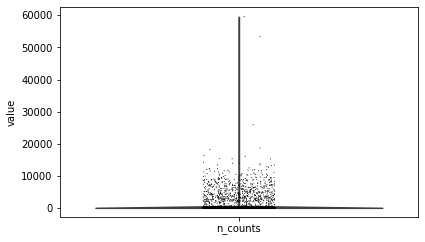

In [26]:
sc.pl.violin(adata, keys='n_counts')

In [27]:
adata.obs['n_countslog'] = np.log1p(adata.obs['n_counts'])

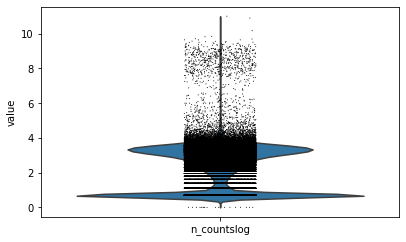

In [28]:
sc.pl.violin(adata, keys='n_countslog')

In [29]:
adata.obs.index

Index(['AAACCCAAGAAACCCA', 'AAACCCAAGACGAGGA', 'AAACCCAAGAGTGTGT',
       'AAACCCAAGAGTGTTG', 'AAACCCAAGATAGCAC', 'AAACCCAAGATGAGTC',
       'AAACCCAAGATGGTAC', 'AAACCCAAGATTCGTT', 'AAACCCAAGATTTGGG',
       'AAACCCAAGCAAGCAT',
       ...
       'TTTGTTGTCGTCGCCT', 'TTTGTTGTCGTTGACG', 'TTTGTTGTCTAACCGG',
       'TTTGTTGTCTATGTAG', 'TTTGTTGTCTCAACAA', 'TTTGTTGTCTCACTCA',
       'TTTGTTGTCTCTTCGA', 'TTTGTTGTCTCTTGGT', 'TTTGTTGTCTGCACTT',
       'TTTGTTGTCTGCGACA'],
      dtype='object', name='barcode', length=124716)

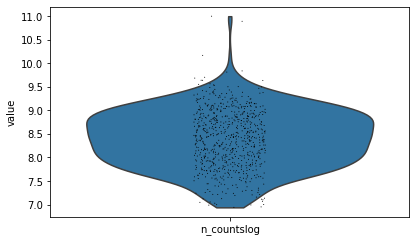

AnnData object with n_obs × n_vars = 725 × 17
    obs: 'n_counts', 'n_countslog'
    var: 'feature_name', 'n_counts'

In [30]:
sc.pp.filter_cells(adata, min_counts=1000)
sc.pl.violin(adata, keys='n_countslog', title="kallisto UMI counts")
adata

Here are violin plots for each Feature Barcode (antibody-oligo conjugates, x-axis) across all cells.

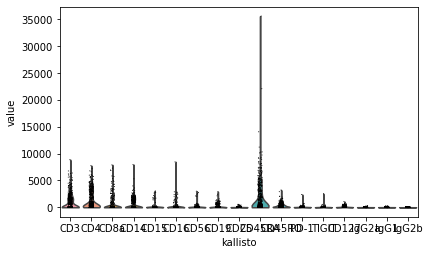

In [31]:
sc.pl.violin(adata, keys=list(adata.var.index)[-17:], xlabel='kallisto')

### Cluster with Leiden

In [32]:
sc.pp.normalize_per_cell(adata, counts_per_cell_after=10000)

In [33]:
sc.pp.neighbors(adata)
sc.tl.umap(adata)

In [34]:
sc.tl.leiden(adata, resolution=0.05)

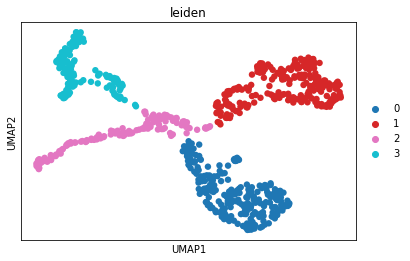

In [35]:
sc.pl.umap(adata, color='leiden', palette='tab10')

### Embedding and Antibody Quantification

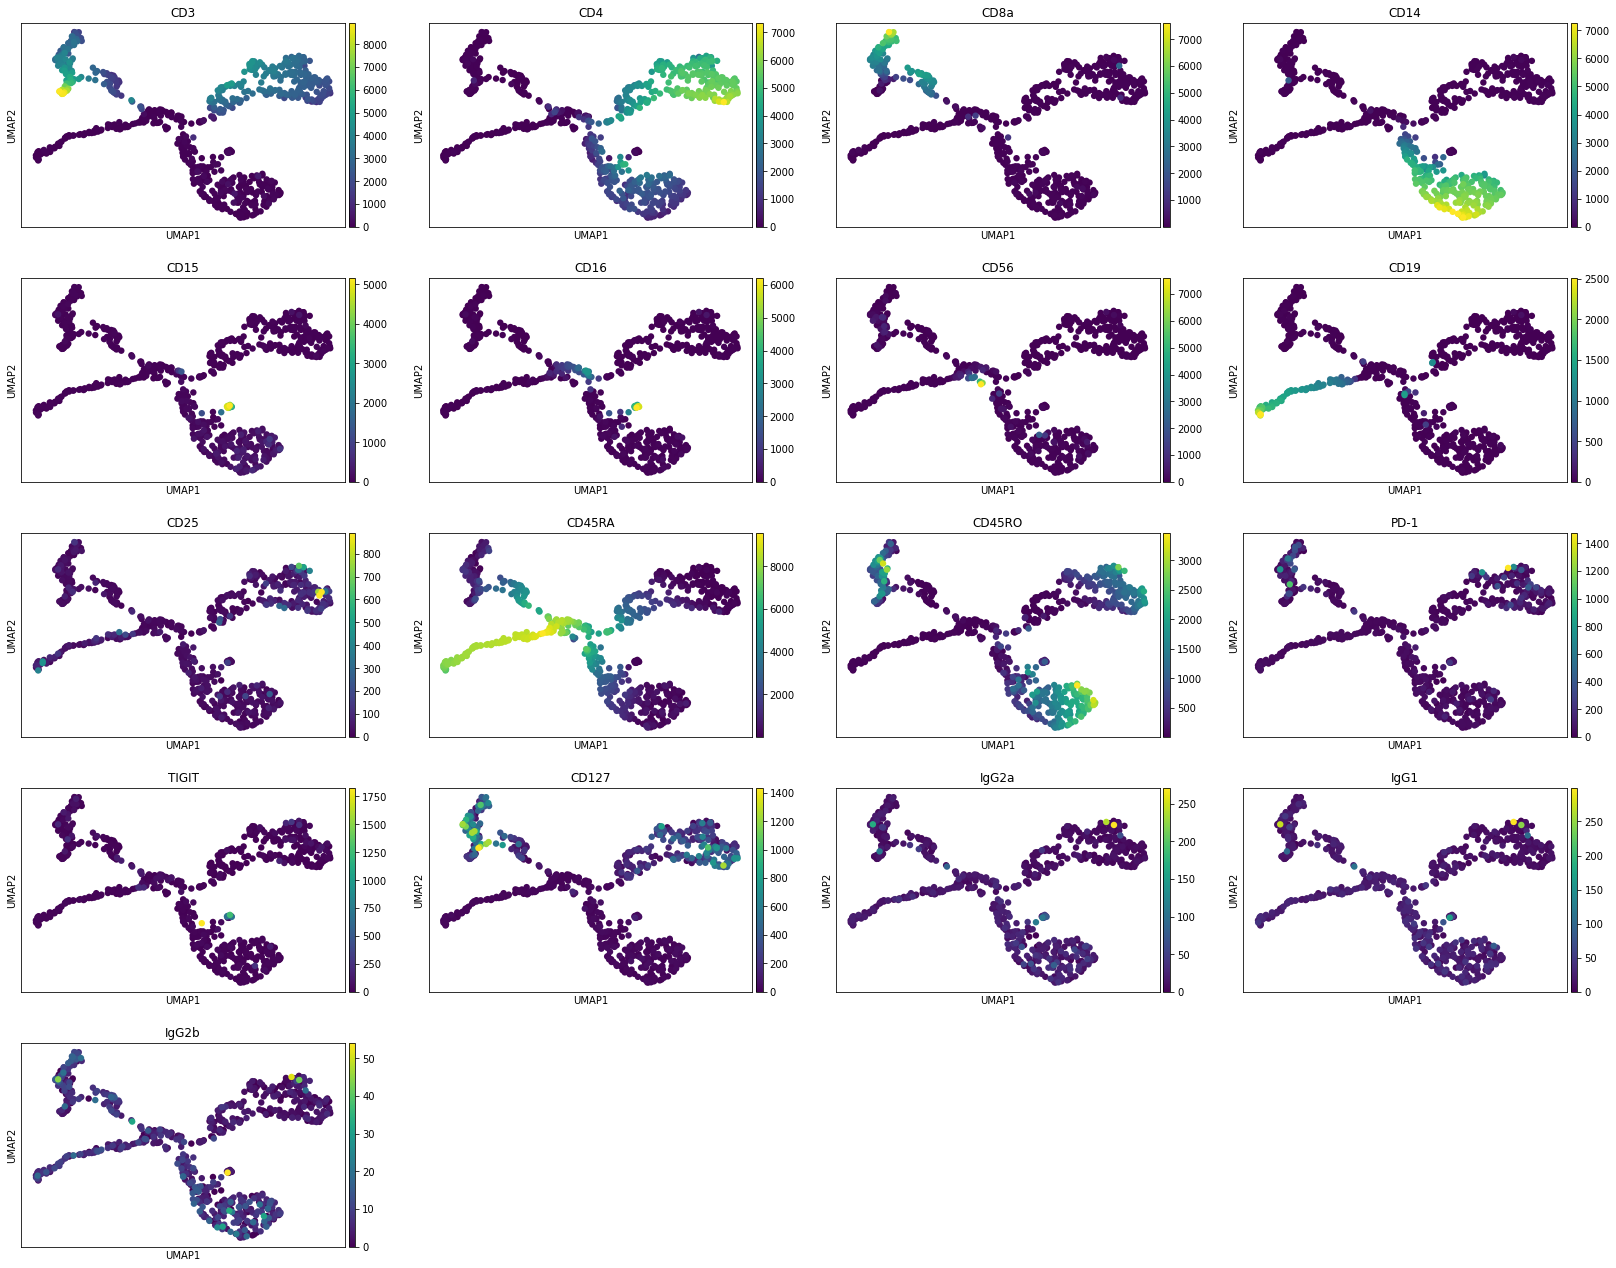

In [36]:
sc.pl.umap(adata, color=adata.var.index)

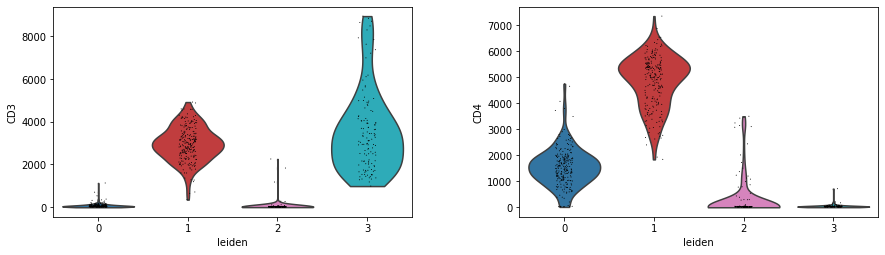

In [37]:
sc.pl.violin(adata, keys=list(adata.var.index[:2]), groupby='leiden')